In [22]:
import sys
import os


sys.path.append(os.path.abspath("/Users/monika/Desktop/DP/DP_QSAR_Skin_Irritation"))
from imports import *

In [23]:
file_path = '../Features/Rabbit_B_SHAP_RF.xlsx'
df = pd.read_excel(file_path)
df.head()

,HallKierAlpha,BertzCT,PEOE_VSA1,TPSA,Chi1,NOCount,HeavyAtomCount,HeavyAtomMolWt,SlogP_VSA2,AvgIpc,LabuteASA,Chi0,Irritation
0,0.511069,0.089220,0.196324,0.234074,0.332727,0.182574,0.244270,0.165640,0.143961,0.452681,0.220079,0.346252,1
1,0.462893,0.146317,0.178444,0.235330,0.349065,0.258199,0.267191,0.199574,0.203511,0.471835,0.235631,0.369599,1
2,0.283431,0.496390,0.261267,0.326708,0.623684,0.365148,0.585838,0.554732,0.241053,0.868672,0.542155,0.635341,0
3,0.295994,0.435679,0.315318,0.426116,0.535387,0.483046,0.478616,0.431023,0.333288,0.710703,0.433421,0.536419,0
4,0.361936,0.402744,0.189052,0.383158,0.526223,0.447214,0.478616,0.473851,0.335075,0.656392,0.465809,0.549662,0


In [24]:
df.shape

(857, 13)

In [25]:
print(df.columns.to_list())

['HallKierAlpha', 'BertzCT', 'PEOE_VSA1', 'TPSA', 'Chi1', 'NOCount', 'HeavyAtomCount', 'HeavyAtomMolWt', 'SlogP_VSA2', 'AvgIpc', 'LabuteASA', 'Chi0', 'Irritation']


In [26]:
# Define features (X) and target variable (y)
X = df.drop(columns=['Irritation'])  
y = df['Irritation']

In [27]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=5)

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (685, 12)
Shape of X_test: (172, 12)
Shape of y_train: (685,)
Shape of y_test: (172,)


In [28]:
import optuna
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

def objective(trial):
    # Define hyperparameter search space with stronger regularization
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),  # Reduce tree count
        "max_depth": trial.suggest_int("max_depth", 3, 5),  # Smaller trees
        "min_samples_split": trial.suggest_int("min_samples_split", 10, 50, step=5),  # Avoid small splits
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 20, step=5),  # Larger leaves
        "max_features": trial.suggest_categorical("max_features", ["sqrt"]),  # Always sqrt for simplicity
        "bootstrap": trial.suggest_categorical("bootstrap", [True]),  # Force bootstrap
        "max_samples": trial.suggest_float("max_samples", 0.5, 0.8)  # Reduce data seen per tree
    }

    # Set up cross-validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    valid_scores = []

    for train_idx, valid_idx in kf.split(X_train, y_train):
        X_train_cv, X_valid_cv = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_cv, y_valid_cv = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        
        model = RandomForestClassifier(**param, random_state=42)
        model.fit(X_train_cv, y_train_cv)
        
        # Compute validation accuracy
        valid_acc = accuracy_score(y_valid_cv, model.predict(X_valid_cv))
        valid_scores.append(valid_acc)

    # Return mean validation accuracy
    return np.mean(valid_scores)

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print best hyperparameters
print("Best trial:", study.best_trial.params)


[I 2025-05-05 18:56:44,076] A new study created in memory with name: no-name-dbb3e95e-9cf5-4c36-bd1f-6f422ce0479c
[I 2025-05-05 18:56:44,780] Trial 0 finished with value: 0.7941605839416057 and parameters: {'n_estimators': 132, 'max_depth': 4, 'min_samples_split': 40, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0.6890221004198538}. Best is trial 0 with value: 0.7941605839416057.
[I 2025-05-05 18:56:45,070] Trial 1 finished with value: 0.7854014598540147 and parameters: {'n_estimators': 72, 'max_depth': 3, 'min_samples_split': 50, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0.5442145702230917}. Best is trial 0 with value: 0.7941605839416057.
[I 2025-05-05 18:56:45,338] Trial 2 finished with value: 0.7927007299270072 and parameters: {'n_estimators': 85, 'max_depth': 3, 'min_samples_split': 30, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0.6048827027194252}. Best is trial 0 wit

Best trial: {'n_estimators': 169, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0.7483581740645409}


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    
best_params = study.best_trial.params

    # Initialize the RandomForest model with the best parameters
final_model = RandomForestClassifier(**best_params)

    # Train the model
final_model.fit(X_train, y_train)


test_accuracy = final_model.score(X_test, y_test)
train_accuracy = final_model.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Predictions
y_pred = final_model.predict(X_test)

# Metrics
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Train Accuracy: 0.8321167883211679
Test Accuracy: 0.8197674418604651
Precision: 0.8153846153846154
Recall: 0.7361111111111112
F1 Score: 0.7737226277372263


In [49]:
test_accuracies = []
train_accuracies = []

for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    
    best_params = study.best_trial.params

    # Initialize the RandomForest model with the best parameters
    final_model = RandomForestClassifier(**best_params)

    # Train the model
    final_model.fit(X_train, y_train)


    test_accuracy = final_model.score(X_test, y_test)
    train_accuracy = final_model.score(X_train, y_train)
    #print("Train Accuracy:", train_accuracy)
    #print("Test Accuracy:", test_accuracy)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

print(np.mean(train_accuracies), np.mean(test_accuracies))

0.8315328467153285 0.8081395348837208


In [58]:

best_params = {'n_estimators': 62, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0.747731027381931}
final_model = RandomForestClassifier(**best_params)

# Train the model
final_model.fit(X_train, y_train)

# Evaluate accuracy on test data
test_accuracy = final_model.score(X_test, y_test)
train_accuracy = final_model.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 0.8350364963503649
Test Accuracy: 0.813953488372093


Train Accuracy: 0.8350364963503649
Test Accuracy: 0.8197674418604651


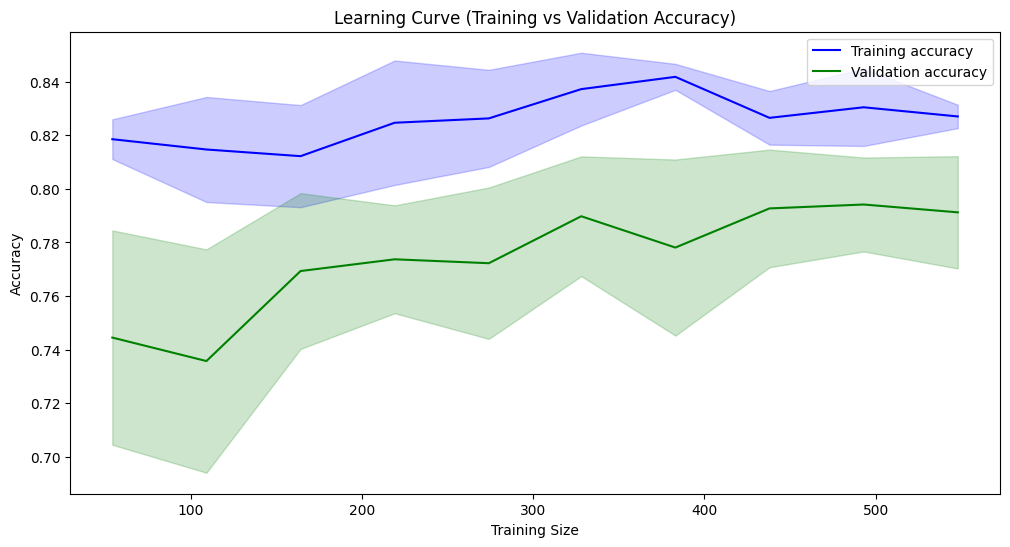

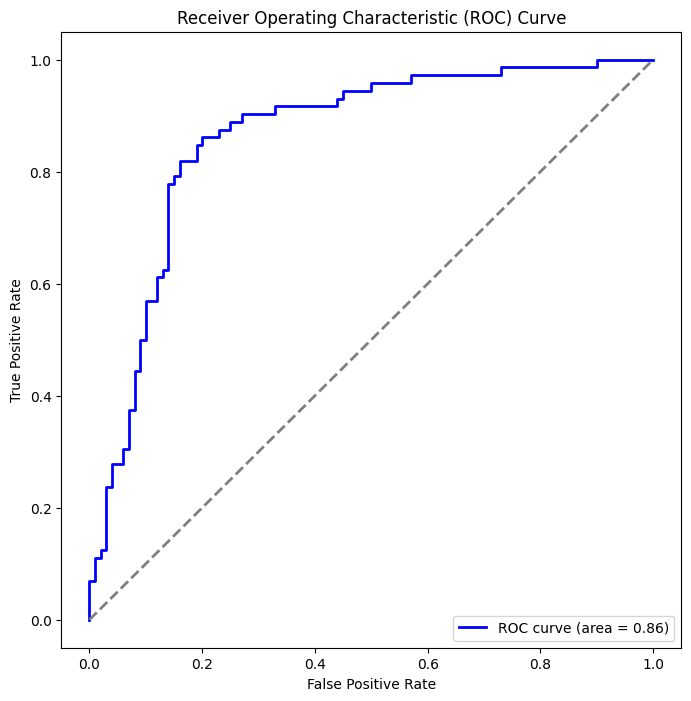

In [59]:
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import learning_curve
# Get best hyperparameters from study 
best_params = study.best_trial.params

# Initialize the RandomForest model with the best parameters
final_model = RandomForestClassifier(**best_params)

# Train the model
final_model.fit(X_train, y_train)

# Evaluate accuracy on test data
test_accuracy = final_model.score(X_test, y_test)
train_accuracy = final_model.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# 1. Learning Curves
train_sizes, train_scores, validation_scores = learning_curve(
    final_model, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, label='Training accuracy', color='blue')
plt.plot(train_sizes, validation_mean, label='Validation accuracy', color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color='green', alpha=0.2)
plt.title('Learning Curve (Training vs Validation Accuracy)')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 2. ROC Curve Plot
# Calculate ROC curve and AUC (Area Under the Curve)
fpr, tpr, thresholds = roc_curve(y_test, final_model.predict_proba(X_test)[:, 1])  # Get probabilities for positive class
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [33]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_train)  # Shape: (samples, features, 2)

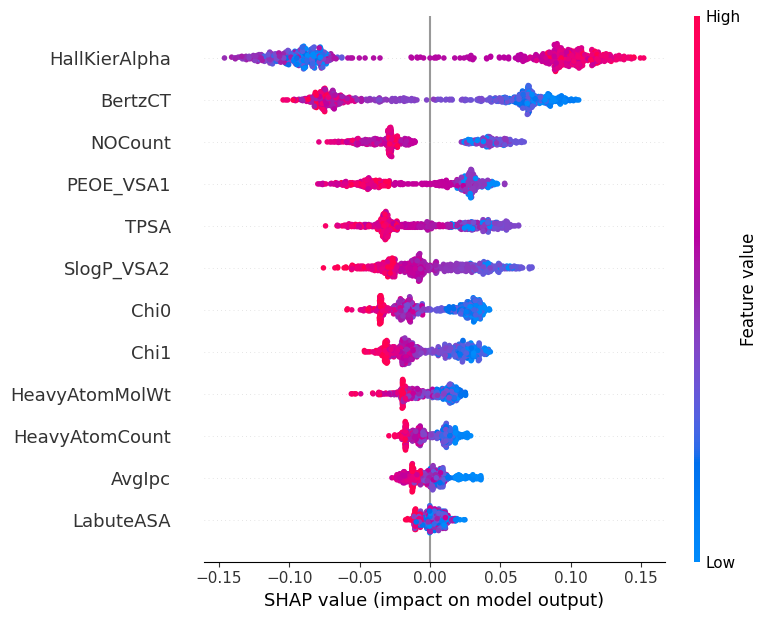

In [34]:
shap.summary_plot(shap_values[:,:,1], X_train)

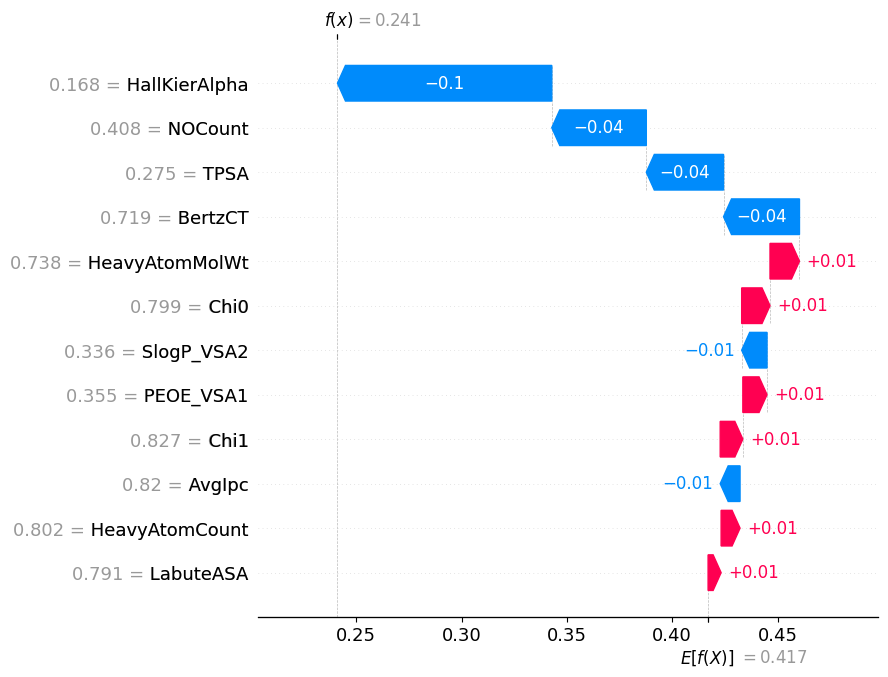

In [35]:
index = 0
shap.waterfall_plot(shap.Explanation(values=shap_values[index,:,1], base_values=explainer.expected_value[1], data=X_test.iloc[index,:]), max_display=20)

In [36]:
print(final_model.get_params()) 

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': 0.7483581740645409, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 10, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 169, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [37]:

important_hyperparams = [
    "n_estimators", "max_depth", "min_samples_split", "min_samples_leaf",
    "max_features", "bootstrap", "criterion", "oob_score",
    "random_state", "class_weight"
]

rf_hyperparams = {param: final_model.get_params()[param] for param in important_hyperparams}
rf_hyperparams

{'n_estimators': 169,
 'max_depth': 5,
 'min_samples_split': 20,
 'min_samples_leaf': 10,
 'max_features': 'sqrt',
 'bootstrap': True,
 'criterion': 'gini',
 'oob_score': False,
 'random_state': None,
 'class_weight': None}

In [38]:
import joblib

joblib.dump(final_model, 'rf_model.pkl')

print("Model saved successfully!")


Model saved successfully!
